In [ ]:
# !git clone https://github.com/williamjohn972/PlantVillage_Leaf_Disease_Classification.git
# %cd PlantVillage_Leaf_Disease_Classification
# !pip install optuna

# from google.colab import files
# files.upload()   # Upload your kaggle.json here

# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d emmarex/plantdisease --unzip

In [4]:
import sys
import os

# Set the project root directory
project_root = os.path.abspath("..")   # one level above /notebooks
sys.path.append(project_root)

**Imports**

In [ ]:
import numpy as np
import random

import optuna
import torch
import torch.nn as nn 
import torch.optim as optim 

from src.train import Trainer
from src.train_utils import build_model, build_trainer, build_optim, calc_class_weights
from src.train_utils import load_train_hist, merge_train_hist, plot_train_summary, plot_confusion_matrix
from src.dataset import get_datasets, create_data_loaders 

**Setting Seed**

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_set, val_set, test_set, classes = get_datasets("../data/PlantVillage",val_split=0.1,test_split=0.1)
num_classes = len(classes)

class_weights = calc_class_weights(train_set, DEVICE) # These weights are to be passed into the loss function later 


In [5]:
print(f"{'-'*10} Class Weights {'-'*10}")
for target, weight in enumerate(class_weights):

    print(f"Class {target}: {weight:.3f}")

---------- Class Weights ----------
Class 0: 0.802
Class 1: 0.541
Class 2: 0.799
Class 3: 0.799
Class 4: 5.240
Class 5: 0.376
Class 6: 0.799
Class 7: 0.419
Class 8: 0.839
Class 9: 0.451
Class 10: 0.477
Class 11: 0.569
Class 12: 0.249
Class 13: 2.138
Class 14: 0.502


**Model Root Directory**

In [2]:
models_root_dir = "../models/resnet_18_001"

# **HyperParam Tuning**

In [10]:
class OptunaPruner:

    def __init__(self, trial: optuna.Trial):
        self.trial = trial

    def __call__(self, trainer: Trainer):

        # Report F1 score (Maximizing metric)
        val_f1_score = trainer.history['val_f1s'][-1]
        self.trial.report(val_f1_score, trainer.cur_epoch)

        # Check for Pruning
        if self.trial.should_prune():
            print(f"Trial {self.trial.number} pruned. Exiting training loop at epoch {trainer.cur_epoch}...")
            raise optuna.TrialPruned()

In [ ]:
EPOCHS = 25

def objective(trial: optuna.Trial):

    # Model HyperParams  
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 256, step=16)
    dropout = trial.suggest_float("dropout", 0.0, 0.7, step=0.1)

    
    # Other Params
    early_stopper_patience = 5
    delta = 1e-4
    lr_patience = early_stopper_patience // 2
    lr_factor = 0.1
    min_lr = 1e-6

    
    # Dataloaders
    train_loader, val_loader, _  = create_data_loaders(train_dataset=train_set,
                                                       val_dataset=val_set,
                                                       test_dataset=None,
                                                       batch_size=batch_size)
    
    # Model
    model = build_model(num_classes=num_classes, dropout=dropout, freeze_base=True,
                        device=DEVICE)
    
    # Loss, Optimizer
    loss_fn = nn.CrossEntropyLoss(weight=class_weights) 
    optim = build_optim(model=model, lr=lr, weight_decay=weight_decay)

                                  
    # Trainer
    trainer = build_trainer(model, loss_fn, optim,
                            early_stopper_patience, delta, False, None,
                            lr_factor, lr_patience, min_lr,
                            DEVICE)

    # Optuna Pruner 
    optuna_pruner = OptunaPruner(trial)
    
    # Train Model
    trainer.train_val_model(epochs=EPOCHS,
                            train_loader=train_loader,
                            val_loader=val_loader, 
                            callback= optuna_pruner)
    
    val_f1 = max(trainer.history['val_f1s'])

    return val_f1

In [ ]:
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=5,
    n_warmup_steps=5,
    interval_steps=1,
)

sampler = optuna.samplers.TPESampler(seed=SEED)

study = optuna.create_study(
    study_name="plant_village_study",
    direction="maximize",    # because we want to maximise the f1 score 
    storage=f"sqlite:///{models_root_dir}/plant_village_study.db",
    load_if_exists=True,
    sampler=sampler,
    pruner=pruner)  

study.optimize(objective, n_trials=20)

print(f"Best trial: {study.best_trial.number}")
print(f"Best val f1-macro: {study.best_value}")
print(f"Best hyperparameters: {study.best_params}")

Best trial: 14
Best val f1-macro: 0.9048782310909461
Best hyperparameters: {'lr': 0.0009753707380279384, 'weight_decay': 2.5208757425689212e-05, 'batch_size': 160, 'dropout': 0.0}


### **Visualize Tuning Results**

In [7]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [13]:
optuna.visualization.plot_slice(study)

In [14]:
optuna.visualization.plot_param_importances(study)

# **ReTrain the Model Using Best HyperParam Combinations**

In [ ]:
study = optuna.load_study(study_name="plant_village_study", storage=f"sqlite:///{models_root_dir}/plant_village_study.db")

In [11]:
# Model HyperParams  
lr = study.best_params["lr"]    # Will Reduce this in Phase 2 
weight_decay = study.best_params["weight_decay"]
batch_size = study.best_params["batch_size"]
dropout = study.best_params["dropout"]

# Dataloaders
train_loader, val_loader, test_loader  = create_data_loaders(train_dataset=train_set,
                                                    val_dataset=val_set,
                                                    test_dataset=test_set,
                                                    batch_size=batch_size)

### **Training Phase 1 - Frozen BackBone**

In [ ]:
EPOCHS = 40 

# Other Params
early_stopper_patience = 7
delta = 1e-4
lr_patience = early_stopper_patience // 2
lr_factor = 0.1
min_lr = 1e-6

# Model
model = build_model(num_classes=num_classes, dropout=dropout, freeze_base=True,
                    device=DEVICE)

# Loss, Optimizer
loss_fn = nn.CrossEntropyLoss(weight=class_weights) 
optim = build_optim(model=model, lr=lr, weight_decay=weight_decay)

                                
# Trainer
trainer = build_trainer(model, loss_fn, optim,
                        early_stopper_patience, delta, True, f"{models_root_dir}/phase_1.pt",
                        lr_factor, lr_patience, min_lr,
                        DEVICE)

trainer.train_val_model(EPOCHS, train_loader=train_loader, val_loader=val_loader)

trainer.save(f"{models_root_dir}/phase_1_train_hist.pkl")

### **Training Phase 2 - Unfrozen**

In [ ]:
EPOCHS = 200 

# HyperParams
lr = 1e-6       # Lowered LR 

# Other Params
early_stopper_patience = 15
delta = 1e-4
lr_patience = early_stopper_patience // 2
lr_factor = 0.5 # Increase the LR Factor as the steps taking are small and we want to be gentle
min_lr = 1e-9

# Load Model
model = build_model(num_classes=num_classes, dropout=dropout, freeze_base=False, 
                    device=DEVICE)

model.load_state_dict(torch.load(f"{models_root_dir}/phase_1.pt")['model_state_dict'])

# Loss, Optimizer
loss_fn = nn.CrossEntropyLoss(weight=class_weights) 
optim = build_optim(model=model, lr=lr, weight_decay=weight_decay)

                                
# Trainer
trainer = build_trainer(model, loss_fn, optim,
                        early_stopper_patience, delta, True, f"{models_root_dir}/final.pt",
                        lr_factor, lr_patience, min_lr,
                        DEVICE)

trainer.train_val_model(EPOCHS, train_loader=train_loader, val_loader=val_loader)

trainer.save(f"{models_root_dir}/phase_2_train_hist.pkl")

### **Plot Curves**

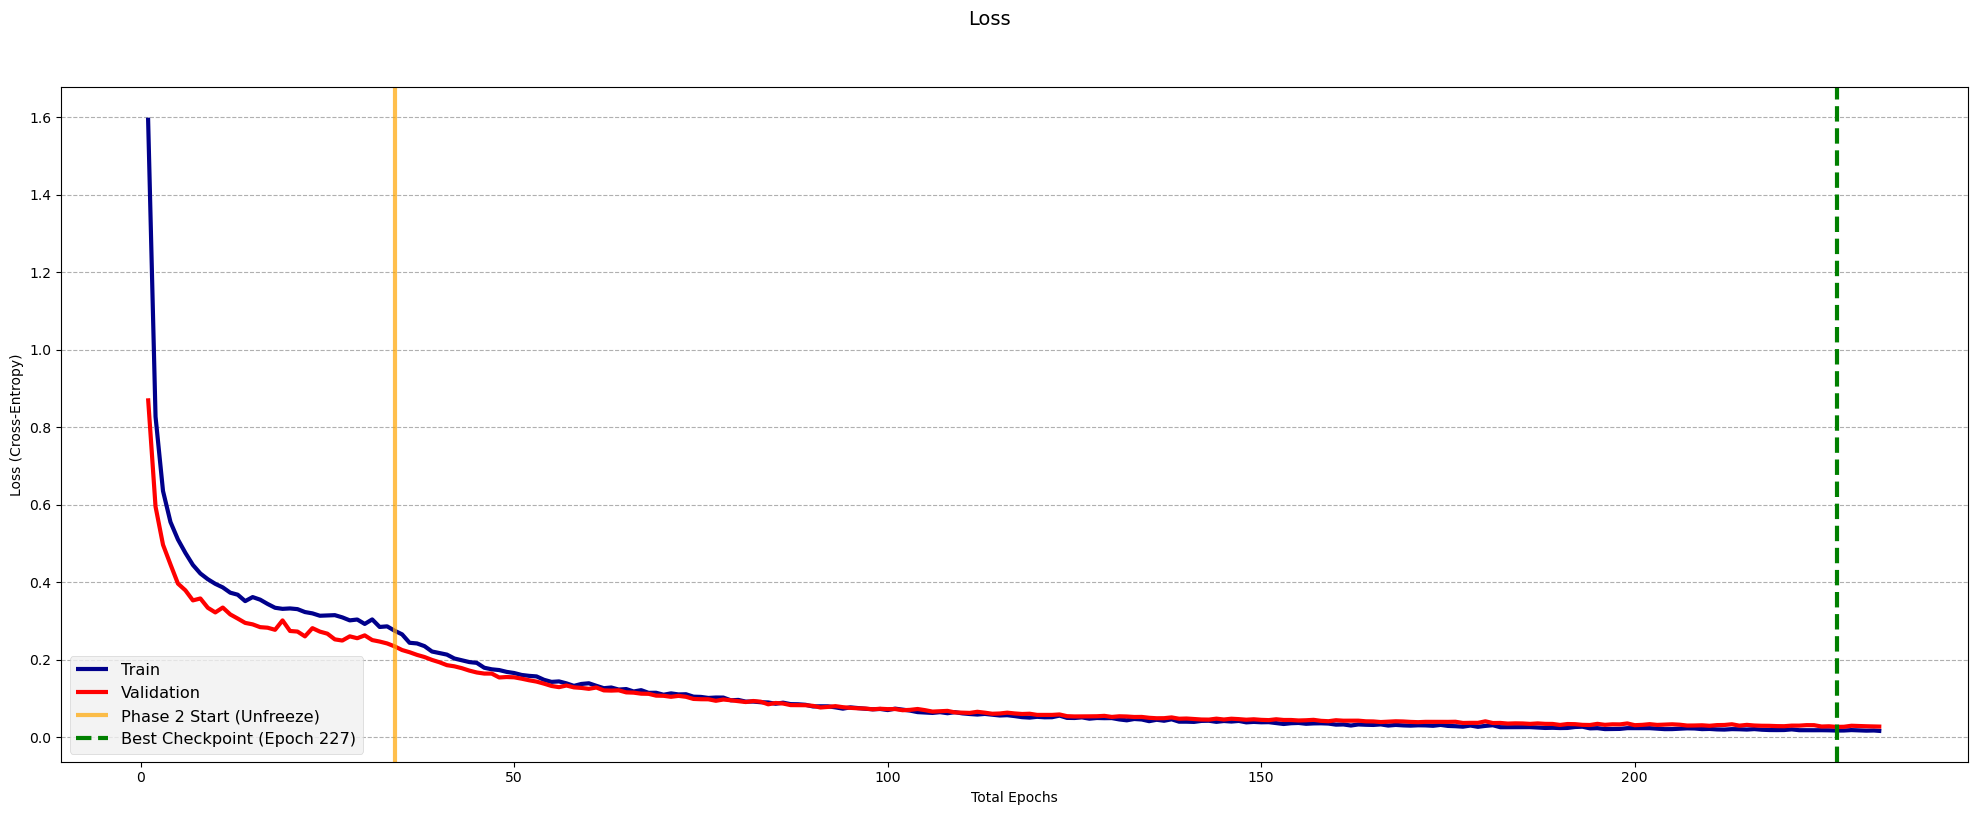

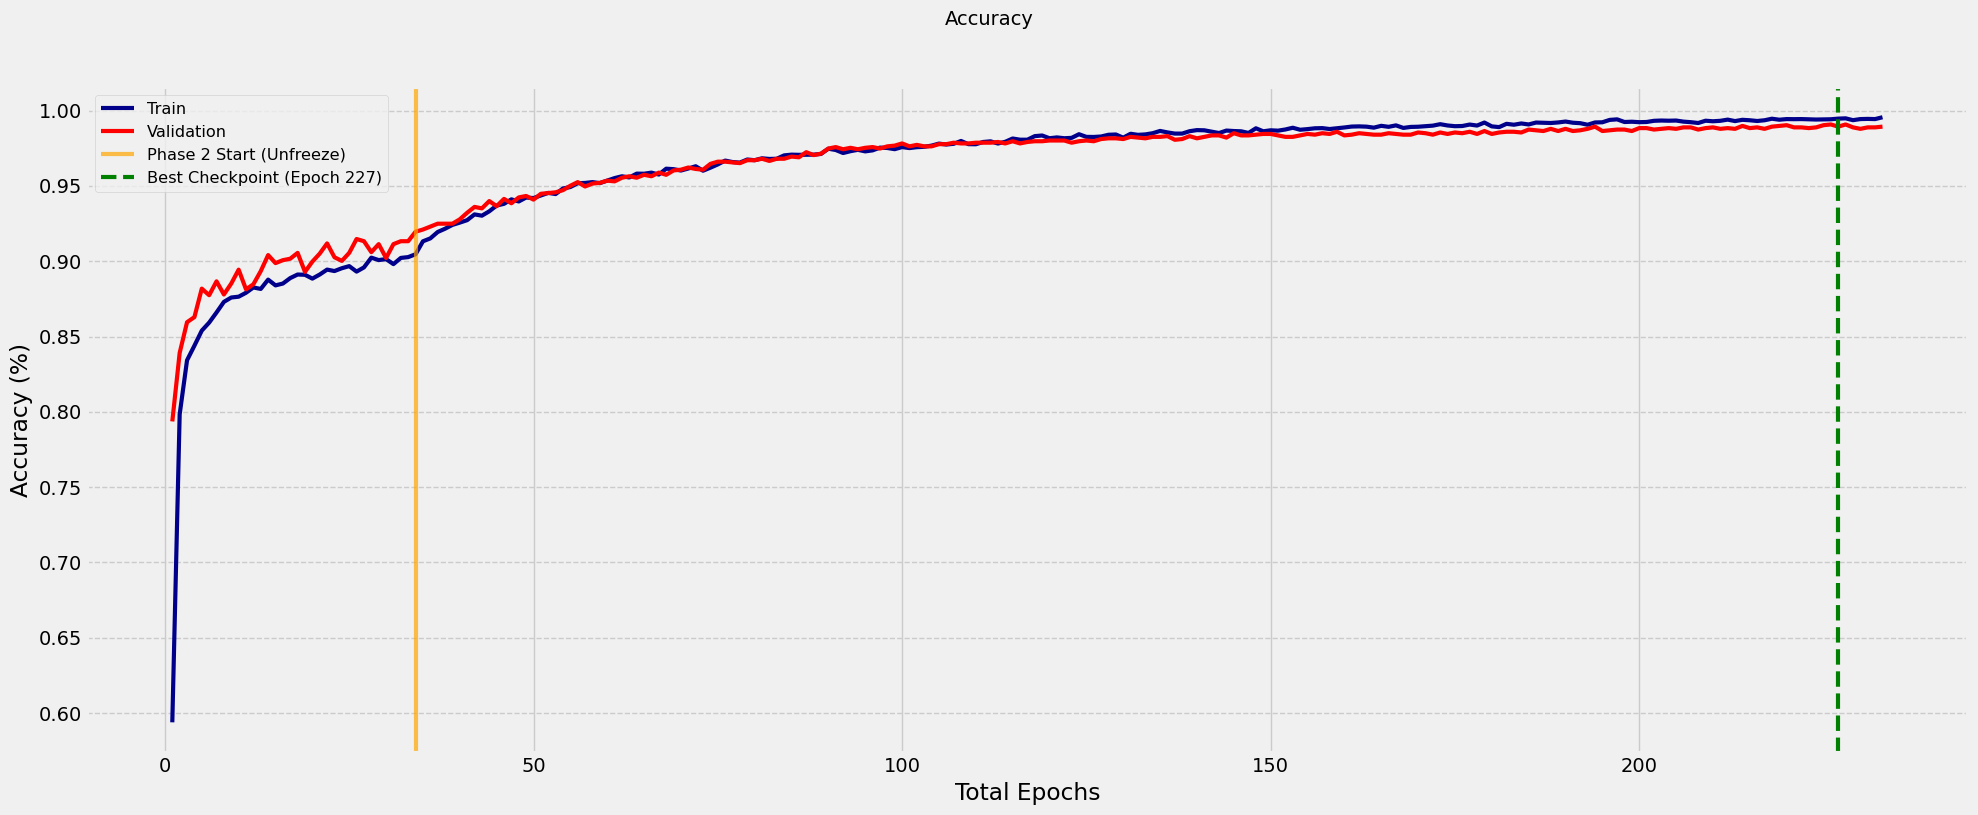

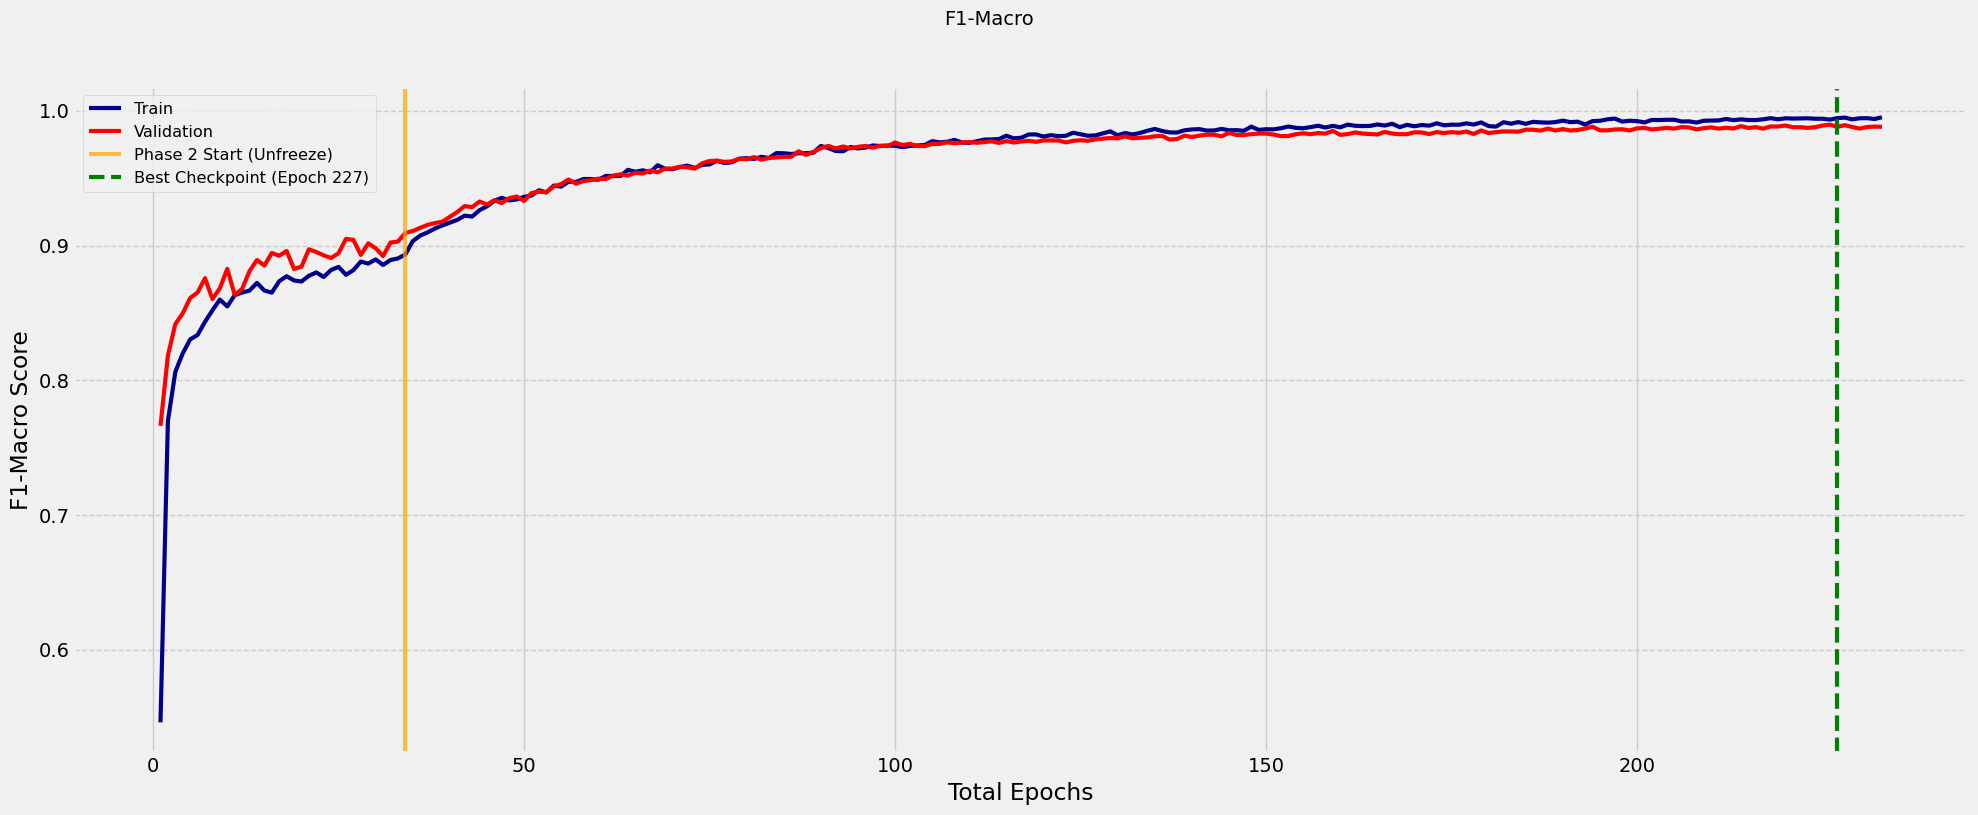

In [6]:
# Load Train Histories (Phase 1 + Phase 2)
train_hist_1 = load_train_hist(f'{models_root_dir}/phase_1_train_hist.pkl')
train_hist_2 = load_train_hist(f'{models_root_dir}/phase_2_train_hist.pkl')

# Concat both the train histories 
train_hist_merged = merge_train_hist(train_hist_1, train_hist_2)

# Plot Summary 
plot_train_summary(
    train_history=train_hist_merged, 
    transition_epoch=train_hist_merged['transition_epoch'],
)

### **Test Model**

In [59]:
# Load Model
model = build_model(num_classes=num_classes, dropout=0, freeze_base=False, 
                    device=DEVICE)
model.load_state_dict(torch.load(f"{models_root_dir}/final.pt", weights_only=True, map_location=DEVICE)['model_state_dict'])

# Loss
loss_fn = nn.CrossEntropyLoss(weight=class_weights) 

# Trainer 
trainer = Trainer(model=model, loss_fn=loss_fn,
                   device=DEVICE)

test_data = trainer.test_model(test_loader, class_names=classes)


--- Test Set Classification Report ---
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      1.00      1.00       100
                     Pepper__bell___healthy       1.00      1.00      1.00       148
                      Potato___Early_blight       1.00      0.99      0.99       100
                       Potato___Late_blight       1.00      1.00      1.00       100
                           Potato___healthy       1.00      1.00      1.00        15
                      Tomato_Bacterial_spot       0.99      1.00      0.99       213
                        Tomato_Early_blight       0.95      0.97      0.96       100
                         Tomato_Late_blight       0.99      0.96      0.98       191
                           Tomato_Leaf_Mold       1.00      0.99      0.99        95
                  Tomato_Septoria_leaf_spot       0.99      1.00      1.00       177
Tomato_Spider_mites_Two_

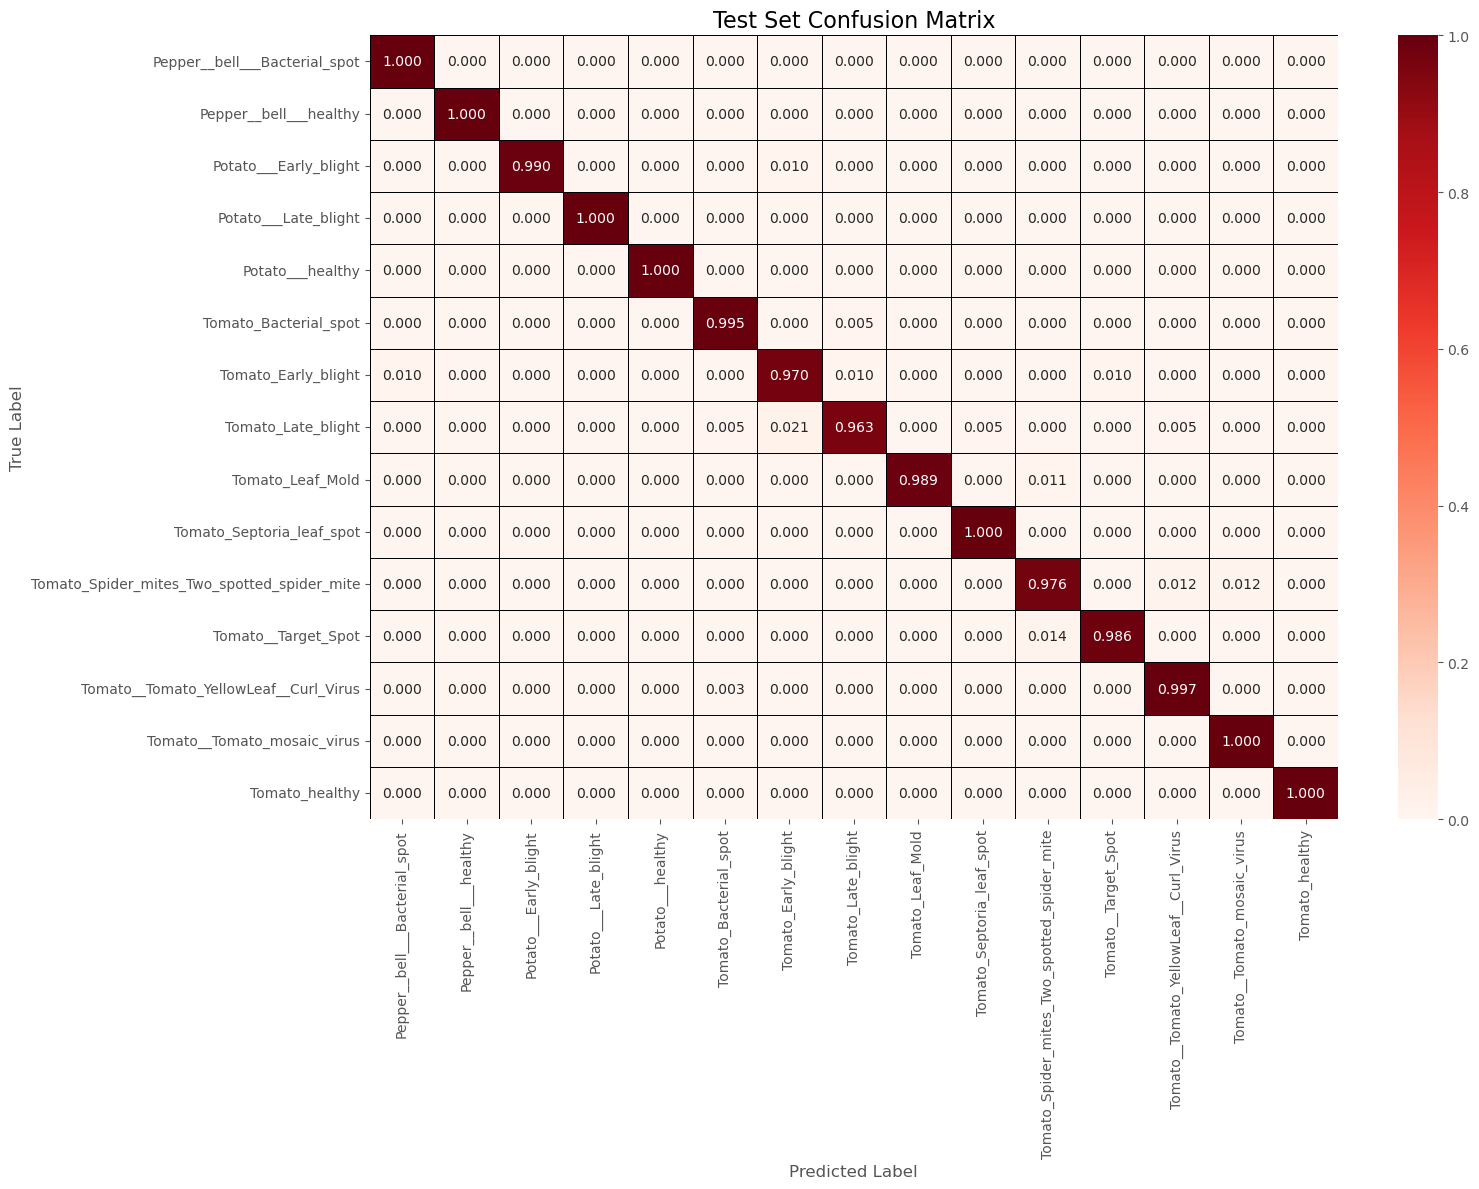

In [70]:
predictions = torch.argmax(test_data['pred_logits'], 1).numpy()
targets = test_data['targets'].numpy()

plot_confusion_matrix(targets, predictions, classes)